# Principles of Data Analysis – Demo 1
**Behavioral • EEG • fMRI**


## Workshop Road‑Map
1. Generate *synthetic* datasets for three modalities  
2. Visualise raw data (signal **&** noise)  
3. Clean / pre‑process step‑by‑step with quality‑control plots  
4. (Bonus) Fit a very small GLM to each cleaned dataset


In [54]:

# --- Imports & Settings ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
!pip install mne
import mne
from ipywidgets import interact, IntSlider, Dropdown
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)
np.random.seed(42)


## 1. Behavioural data: reaction times

In [8]:

# Generate synthetic RTs
n = 300
rt = np.random.normal(500, 80, n)

# Add anticipations (<150 ms) and slow outliers (>800 ms)
anticip_idx = np.random.choice(n, 10, replace=False)
slow_idx = np.random.choice(list(set(range(n)) - set(anticip_idx)), 10, replace=False)
rt[anticip_idx] = np.random.normal(120, 15, size=len(anticip_idx))
rt[slow_idx] = np.random.normal(900, 50, size=len(slow_idx))

rt_df = pd.DataFrame({'RT_ms': rt})
rt_df.head()


,RT_ms
0,539.737132
1,488.938856
2,551.815083
3,621.842389
4,481.267730


**QC‑1: raw distribution**

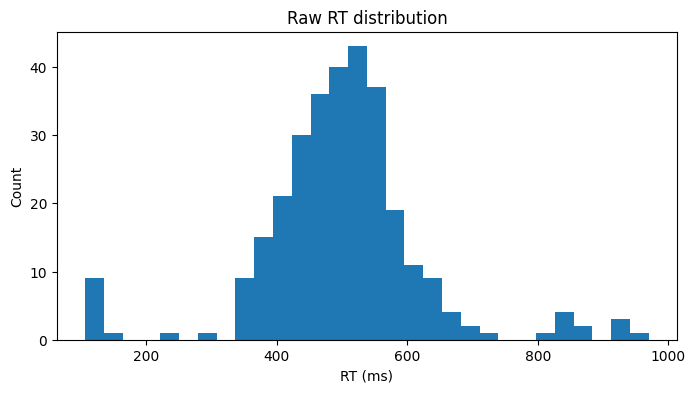

In [9]:

plt.hist(rt_df['RT_ms'], bins=30)
plt.xlabel('RT (ms)'); plt.ylabel('Count'); plt.title('Raw RT distribution');


### Cleaning steps
1. Drop anticipations (<150 ms)
2. Winsorise > mean + 3 SD

In [10]:

# Drop anticipations
rt_clean = rt_df[rt_df['RT_ms'] >= 150].copy()

# Winsorise high values
upper = rt_clean['RT_ms'].mean() + 3*rt_clean['RT_ms'].std()
rt_clean['RT_ms_wins'] = np.clip(rt_clean['RT_ms'], None, upper)

rt_clean.describe()


,RT_ms,RT_ms_wins
count,290.000000,290.000000
mean,512.277678,510.400265
std,105.872762,99.182009
min,240.698613,240.698613
25%,445.660077,445.660077
50%,505.534602,505.534602
75%,554.018478,554.018478
max,969.858221,829.895964


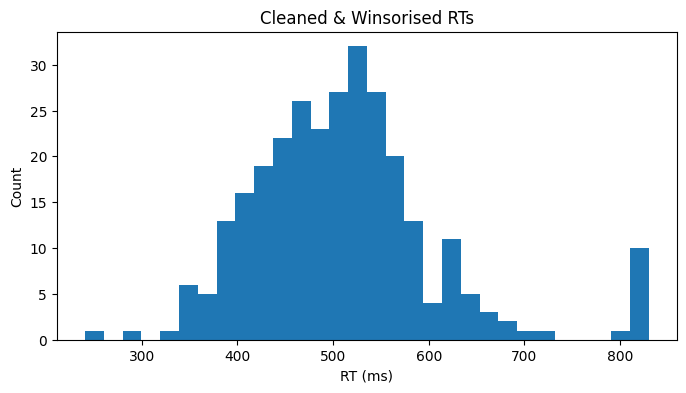

In [11]:

plt.hist(rt_clean['RT_ms_wins'], bins=30)
plt.xlabel('RT (ms)'); plt.ylabel('Count'); plt.title('Cleaned & Winsorised RTs');


## 2. EEG: simulated ERP with blinks

In [78]:
# Simulate simple EEG waveform: 64 channels, 200 samples per trial, 120 trials
fs = 256  # Hz
t = np.arange(0, 2, 1/fs)
n_ch, n_trials = 16, 10

# Base ERP (sinusoid 10 Hz, decays)
erp = np.sin(2*np.pi*10*t) * np.exp(-t*4)

# Channel gains and noise
data = np.zeros((n_ch, len(t), n_trials))
for tr in range(n_trials):
    noise = np.random.normal(0, 0.5, size=(n_ch, len(t)))
    data[:,:,tr] = erp.reshape((1,-1)) + noise

# Add blink artefact to Fp1 (channel 0) on 20% trials (large deflection)
blink_trials = np.random.choice(n_trials, int(0.4*n_trials), replace=False)
for tr in blink_trials:
    blink = signal.windows.gaussian(len(t), std=20) * 5  # sharp peak
    data[0,:,tr] += blink
    data[7,:,tr] += blink

# Average across trials
erp_avg = data.mean(axis=2)

In [79]:
# Create MNE info structure
ch_names = ['Fp1', 'F7', 'F3', 'T7', 'C3', 'P7', 'P3',  # Left hemisphere
            'Fp2', 'F8', 'F4', 'T8', 'C4', 'P4',        # Right hemisphere
            'Fz', 'Cz', 'Pz']
info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types='eeg')

def plot_trial(trial_num):
    """Plot all channels for selected trial using MNE"""
    trial_data = data[:, :, trial_num]

    # Create MNE Raw object
    raw = mne.io.RawArray(trial_data, info, verbose=False)

    # Set montage for proper channel positions
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Plot using MNE
    fig = raw.plot(duration=2, n_channels=16, scalings='auto',
                   title=f'Trial {trial_num}', show=False, block=False)

    # Add blink annotation
    if trial_num in blink_trials:
        fig.suptitle(f'Trial {trial_num} - BLINK TRIAL', color='red', fontweight='bold')

    plt.show()


# Create dropdown options
trial_options = [(f'Trial {i}', i) for i in range(n_trials)]

interact(plot_trial,
         trial_num=Dropdown(options=trial_options,
                           value=0,
                           description='Select Trial:',
                           style={'description_width': 'initial'}))

interactive(children=(Dropdown(description='Select Trial:', options=(('Trial 0', 0), ('Trial 1', 1), ('Trial 2…

<function __main__.plot_trial(trial_num)>

**QC‑2: raw vs filtered (band‑pass 1‑30 Hz) – channel Fp1**

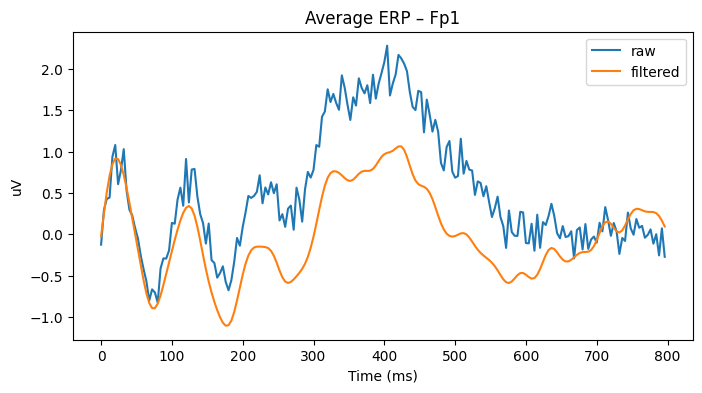

In [65]:

# Band‑pass filter
sos = signal.butter(4, [1, 30], btype='band', fs=fs, output='sos')
data_filt = signal.sosfiltfilt(sos, data, axis=1)
erp_avg_filt = data_filt.mean(axis=2)

plt.figure(figsize=(8,4))
plt.plot(t*1e3, erp_avg[0], label='raw')
plt.plot(t*1e3, erp_avg_filt[0], label='filtered')
plt.xlabel('Time (ms)'); plt.ylabel('uV'); plt.legend(); plt.title('Average ERP – Fp1');


## 3. fMRI: single‑voxel time‑series with motion spikes

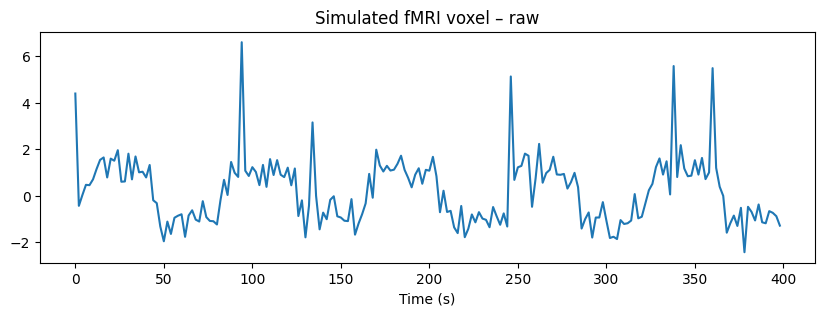

In [26]:
# Simulate task design: 200 timepoints, TR=2s, blocks ON (20 TR) / OFF (20 TR)
TR = 2.0
n_tp = 200
design = np.zeros(n_tp)
for block_start in range(0, n_tp, 40):
    design[block_start:block_start+20] = 1

# Simple HRF: gamma
from scipy.stats import gamma
hrf_t = np.arange(0, 32, TR)
hrf = gamma.pdf(hrf_t, 6)

bold = np.convolve(design, hrf)[:n_tp]
bold = (bold - bold.mean()) / bold.std()

# Add noise
bold += np.random.normal(0, 0.5, n_tp)

# Add motion spikes at random points
spike_idx = np.random.choice(n_tp, 6, replace=False)
bold[spike_idx] += np.random.normal(5, 0.5, len(spike_idx))

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.arange(n_tp)*TR, bold)
ax.set_xlabel('Time (s)'); ax.set_title('Simulated fMRI voxel – raw');

### Despiking & high‑pass filter (0.01 Hz)

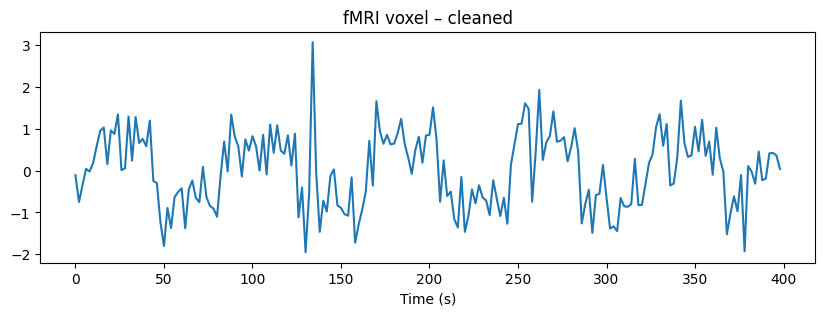

In [28]:

# Despike by median absolute deviation threshold
import statsmodels.api as sm
mad = np.median(np.abs(bold - np.median(bold)))
th = 3 * mad
bold_despike = bold.copy()
bold_despike[np.abs(bold_despike - np.median(bold)) > th] = np.median(bold)

# High‑pass (butterworth) >0.01 Hz
hp_sos = signal.butter(2, 0.01, btype='highpass', fs=1/TR, output='sos')
bold_hp = signal.sosfiltfilt(hp_sos, bold_despike)

plt.figure(figsize=(10,3))
plt.plot(np.arange(n_tp)*TR, bold_hp)
plt.xlabel('Time (s)'); plt.title('fMRI voxel – cleaned');


### Quick GLM fit

In [23]:

import statsmodels.api as sm
X = sm.add_constant(design)  # intercept + task regressor
model = sm.OLS(bold_hp, X).fit()
print(model.summary().tables[1])


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4734      0.079     -5.959      0.000      -0.630      -0.317
x1             1.0348      0.112      9.212      0.000       0.813       1.256


After running the cell above, you should be able to execute the plotting cell again and get an interactive plot.